In [ ]:
from ase import Atoms
from ase.build import molecule
from ase.io import write, read
import numpy as np
from scipy.spatial.transform import Rotation as R
from tkinter.filedialog import askopenfilename

# CIF 파일에서 셀 크기 읽기
cif_path = askopenfilename(title="Select CIF file", filetypes=[("CIF files", "*.cif")])
slab = read(cif_path)
cell = slab.get_cell()
box_x, box_y, box_z, alpha, beta, gamma = slab.get_cell_lengths_and_angles()

z_surface = 10.0      # 표면 z 위치
z_offset = 3.0        # 표면에서 띄울 높이

# 배치 설정
num_waters = 40
spacing = 2.8  # 물 분자 간 최소 간격
start_z = z_surface + z_offset

# 셀 벡터
a_vec, b_vec, _ = cell[0], cell[1], cell[2]

# 물 분자 정의
water = molecule('H2O')
water.translate(-water.get_center_of_mass())  # 원점 중심화

waters = []
placed = 0
max_i = int(box_x // spacing)
max_j = int(box_y // spacing)
max_k = int((box_z - start_z) // spacing)

for k in range(max_k):
    for j in range(max_j):
        for i in range(max_i):
            if placed >= num_waters:
                break

            # 격자 벡터 기반 위치 생성
            pos_vector = i * spacing * a_vec / np.linalg.norm(a_vec) + \
                         j * spacing * b_vec / np.linalg.norm(b_vec) + \
                         k * spacing * np.array([0, 0, 1]) + \
                         np.array([0, 0, start_z])

            if pos_vector[2] > (box_z - spacing):
                print("Reached top of cell. Stopping placement.")
                break

            new = water.copy()

            # 무작위 회전 적용
            rot = R.random().as_matrix()
            new.positions = np.dot(new.positions, rot.T)

            new.translate(pos_vector)
            waters.append(new)
            placed += 1

# 병합
combined = sum(waters[1:], waters[0].copy()) if waters else Atoms()
combined.set_cell(cell)
combined.set_pbc([True, True, True])

# 저장 (CIF 파일 형식)
write('water_ordered_on_surface.cif', combined)
print(f"{len(combined)} atoms written to 'water_ordered_on_surface.cif'")


120 atoms written to 'water_ordered_on_surface.cif'


In [ ]:
from ase import Atoms
from ase.build import molecule
from ase.io import write, read
import numpy as np
from scipy.spatial.transform import Rotation as R
from tkinter.filedialog import askopenfilename

# CIF 파일에서 셀 parameter 읽기
cif_path = askopenfilename(title="Select CIF file", filetypes=[("CIF files", "*.cif")])
slab = read(cif_path)
cell = slab.get_cell()
box_x, box_y, box_z, alpha, beta, gamma = slab.get_cell_lengths_and_angles()

# slab에서 가장 큰 z 값을 가진 원소 기준으로 z_surface 설정
z_surface = max(slab.positions[:, 2])
z_offset = 3.0  # 표면에서 띄울 높이

# 층 수 입력
num_layers = 3  # 사용자 정의 층 수
min_spacing = 2.4  # 사용자 정의 최소 간격
start_z = z_surface + z_offset

# 셀 벡터
a_vec, b_vec, c_vec = cell[0], cell[1], cell[2]

# i, j 방향으로 최대 분자 수
max_i = int(np.linalg.norm(a_vec) // min_spacing)
max_j = int(np.linalg.norm(b_vec) // min_spacing)

# spacing 재계산 (모든 분자들이 PBC 하에 동일 간격을 갖도록 조정)
adjusted_spacing_x = np.linalg.norm(a_vec) / max_i if max_i > 0 else np.linalg.norm(a_vec)
adjusted_spacing_y = np.linalg.norm(b_vec) / max_j if max_j > 0 else np.linalg.norm(b_vec)

# 시작 위치를 중심 정렬로 재조정
origin_shift_x = (np.linalg.norm(a_vec) - (max_i - 1) * adjusted_spacing_x) / 2 if max_i > 1 else 0
origin_shift_y = (np.linalg.norm(b_vec) - (max_j - 1) * adjusted_spacing_y) / 2 if max_j > 1 else 0

# 물 분자 정의
water = molecule('H2O')
water.translate(-water.get_center_of_mass())  # 원점 중심화

waters = []

for k in range(num_layers):
    for j in range(max_j):
        for i in range(max_i):
            # 격자 벡터 기반 위치 생성
            pos_vector = i * adjusted_spacing_x * a_vec / np.linalg.norm(a_vec) + \
                         j * adjusted_spacing_y * b_vec / np.linalg.norm(b_vec) + \
                         k * min_spacing * np.array([0, 0, 1]) + \
                         origin_shift_x * a_vec / np.linalg.norm(a_vec) + \
                         origin_shift_y * b_vec / np.linalg.norm(b_vec) + \
                         np.array([0, 0, start_z])

            if pos_vector[2] > (box_z - min_spacing):
                print("Reached top of cell. Stopping placement.")
                break

            new = water.copy()

            # 무작위 회전 적용
            rot = R.random().as_matrix()
            new.positions = np.dot(new.positions, rot.T)

            new.translate(pos_vector)
            waters.append(new)

# 병합
combined = sum(waters[1:], waters[0].copy()) if waters else Atoms()
combined += slab  # slab과 결합
combined.set_cell(cell)
combined.set_pbc([True, True, True])

# 저장 (CIF 파일 형식)
write('water_ordered_on_surface.cif', combined)
print(f"{len(combined)} atoms written to 'water_ordered_on_surface.cif'")

351 atoms written to 'water_ordered_on_surface.cif'


In [ ]:
from ase.io import read, write
from MDAnalysis import Universe

# ASE에서 Cartesian 변환된 XYZ 저장
atoms_1 = read("XDATCAR", index=":")
write("traj.xyz", atoms_1)



In [34]:
from ase.io import read, write
from ase.geometry.cell import cellpar_to_cell
from ase.visualize import view

filename = "CeO2_Cu"

cif_atoms = read(f"{filename}.cif")
cell = cif_atoms.get_cell()

# 3. XYZ 위치 데이터 읽기 (격자 정보 무시)
frames = read(f"{filename}.xyz", index=':')


for atoms_1 in frames:
    atoms_1.set_cell(cell)
    atoms_1.set_pbc([True, True, True])

write(f"{filename}.traj", frames)


In [20]:
from ase import Atoms
from ase.visualize import view

atoms = Atoms()
atoms.edit()


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\MDAnalysis\analysis\base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time


0.8663324278025221
0.8443193213370631
0.6439937450210229


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\MDAnalysis\analysis\rdf.py:369: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\MDAnalysis\analysis\rdf.py:359: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


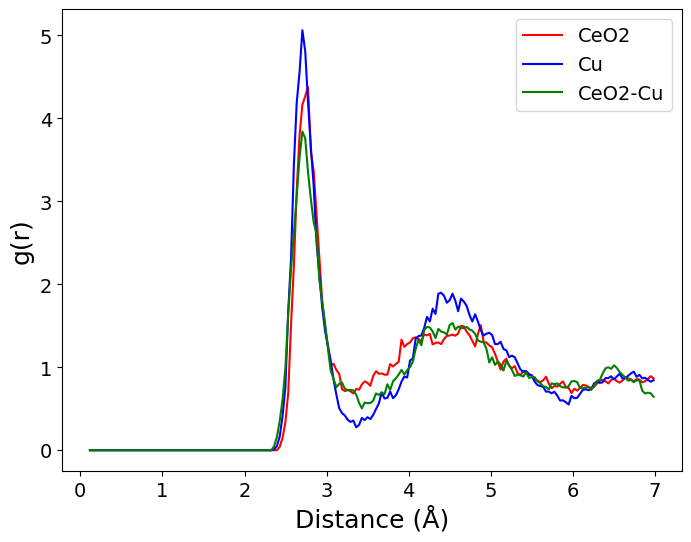

In [29]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from math import cos, sin, pi, sqrt
from ase.io import read

# CIF 파일 읽기
atoms_1 = read("CeO2.cif")
atoms_2 = read("Cu.cif")
atoms_3 = read("CeO2_Cu.cif")

# 격자 벡터 lengths
cellpar1 = atoms_1.cell.cellpar()
cellpar2 = atoms_2.cell.cellpar()
cellpar3 = atoms_3.cell.cellpar()


## convert angles to radians
#alpha_r, beta_r, gamma_r = map(lambda x: x * pi / 180, (alpha, beta, gamma))
#
## volume formula for triclinic cell
#volume = a * b * c * sqrt(
#    1 - cos(alpha_r)**2 - cos(beta_r)**2 - cos(gamma_r)**2 +
#    2 * cos(alpha_r) * cos(beta_r) * cos(gamma_r)
#)
#
#print(f"Cell volume: {volume:.3f} Å³")

# Read trajectory file using MDAnalysis
u1 = mda.Universe("CeO2.xyz")
u2 = mda.Universe("Cu.xyz")
u3 = mda.Universe("CeO2_Cu.xyz")

u1.dimensions = np.array(cellpar1)
u2.dimensions = np.array(cellpar2)
u3.dimensions = np.array(cellpar3)



u1_ag1 = u1.select_atoms('bynum 241:288')
u1_ag2 = u1.select_atoms('bynum 241:288')

u2_ag1 = u2.select_atoms('bynum 241:288')
u2_ag2 = u2.select_atoms('bynum 241:288')

u3_ag1 = u3.select_atoms('bynum 217:261')
u3_ag2 = u3.select_atoms('bynum 217:261')


# number density calculation (from all O atoms)
#n_all = len(ag2)
#rho_all = n_all / volume
#print(n_all)
#print(f"Number density of O: {rho_all:.6f} atoms/Å³")

# RDF 계산
rdf1 = InterRDF(u1_ag1, u1_ag2, nbins=200, range=(0.1, 7.0), norm="density")
rdf1.run(start=100, stop=1000, step=1)

rdf2 = InterRDF(u2_ag1, u2_ag2, nbins=200, range=(0.1, 7.0), norm="density")
rdf2.run(start=1000, stop=2000, step=1)

rdf3 = InterRDF(u3_ag1, u3_ag2, nbins=200, range=(0.1, 7.0), norm="density")
rdf3.run(start=100, stop=1000, step=1)

print(rdf1.rdf[199])
print(rdf2.rdf[199])
print(rdf3.rdf[199])

# 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(rdf1.bins, rdf1.rdf, label='CeO2', color='red')
plt.plot(rdf2.bins, rdf2.rdf, label='Cu', color='blue')
plt.plot(rdf3.bins, rdf3.rdf, label='CeO2-Cu', color='green')

#plt.plot(rdf1.bins, rdf1.rdf / rdf1.rdf[199], label='CeO2', color='red')
#plt.plot(rdf2.bins, rdf2.rdf / rdf2.rdf[199], label='Cu', color='blue')
#plt.plot(rdf3.bins, rdf3.rdf / rdf3.rdf[199], label='CeO2-Cu', color='green')

#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')
plt.show()

## Coordination Number 
#r = rdf.bins
#dr = r[1] - r[0]
#
#cn = np.cumsum(4 * pi * r**2 * rdf.rdf * dr)
#
## Coordination number 시각화
#plt.figure()
#plt.plot(r, cn)
#
##plt.xlim(0, 6)
##plt.ylim(0, 5)
#
#plt.xlabel('Distance (Å)')
#plt.ylabel('Coordination Number')
#plt.title('Coordination Number vs Distance')
#plt.grid(True)
#plt.show()

Cell volume: 7814.897 Å³
128
Number density of O: 0.016379 atoms/Å³
3.31880694238699


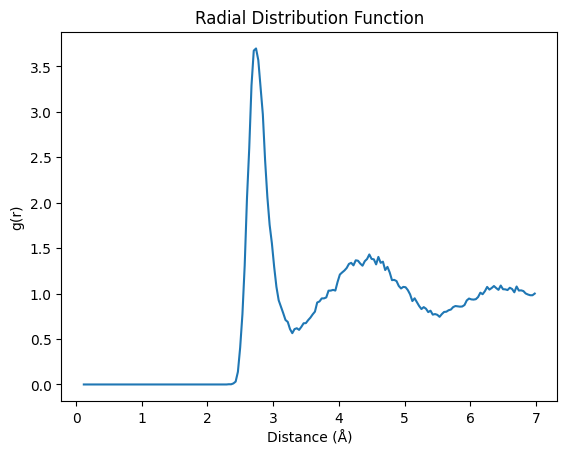

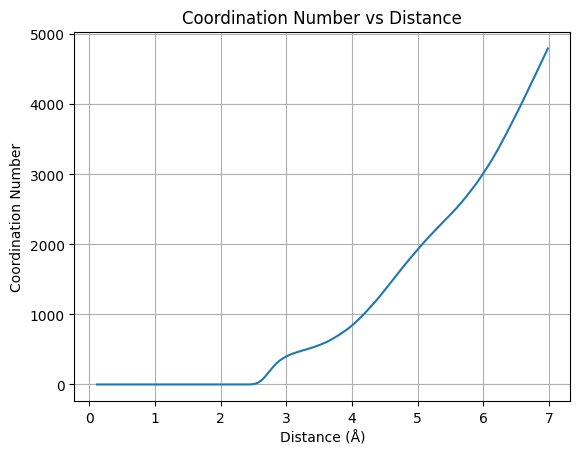

In [64]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from math import cos, sin, pi, sqrt


# Cell parameters
a, b, c = 17.30641728, 15.05202152, 30  # in Å
alpha, beta, gamma = 90, 90, 90  # in degrees

# convert angles to radians
alpha_r, beta_r, gamma_r = map(lambda x: x * pi / 180, (alpha, beta, gamma))

# volume formula for triclinic cell
volume = a * b * c * sqrt(
    1 - cos(alpha_r)**2 - cos(beta_r)**2 - cos(gamma_r)**2 +
    2 * cos(alpha_r) * cos(beta_r) * cos(gamma_r)
)

print(f"Cell volume: {volume:.3f} Å³")

# Read trajectory file using MDAnalysis
u = mda.Universe("AIMD_simulation-pos-1.xyz")
u.dimensions = np.array([a, b, c, alpha, beta, gamma])

# 원자 그룹 선택
ag1 = u.select_atoms('type O')
ag2 = u.select_atoms('type O')

#ag1 = u.select_atoms('bynum 217:261')
#ag2 = u.select_atoms('bynum 217:261')

# number density calculation (from all O atoms)
n_all = len(ag2)
rho_all = n_all / volume
print(n_all)
print(f"Number density of O: {rho_all:.6f} atoms/Å³")

# RDF 계산
rdf = InterRDF(ag1, ag2, nbins=200, range=(0.1, 7.0), norm="density")
rdf.run(start=2000, stop=3000, step=1)

print(rdf.rdf[199])

# 결과 시각화
plt.plot(rdf.bins, rdf.rdf / 3.31880694238699, label='RDF')
plt.xlabel('Distance (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.show()

# Coordination Number 
r = rdf.bins
dr = r[1] - r[0]

cn = np.cumsum(4 * pi * r**2 * rdf.rdf * dr)

# Coordination number 시각화
plt.figure()
plt.plot(r, cn)
plt.xlabel('Distance (Å)')
plt.ylabel('Coordination Number')
plt.title('Coordination Number vs Distance')
plt.grid(True)
plt.show()

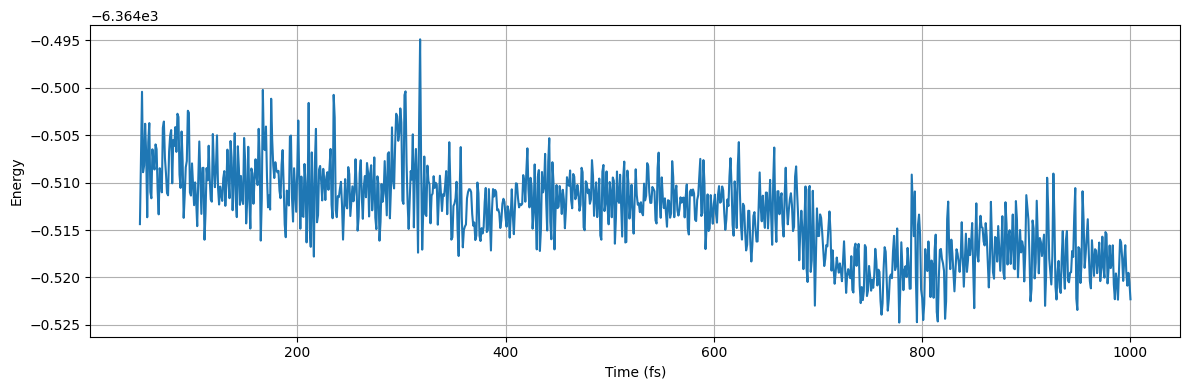

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# —————————————————————————————————————————————————————
# 1. 파일 경로 및 이름 설정
#    실제 프로젝트 이름에 맞춰 아래 변수를 수정하세요.
# —————————————————————————————————————————————————————
ener_file = "CeO2_Cu.ener"  # 예: 'water-1.ener'

# —————————————————————————————————————————————————————
# 2. .ener 파일 읽기
#    skiprows=1 로 헤더(# 로 시작하는 첫 줄)를 건너뛰고, 
#    usecols로 필요한 열(시간, 총에너지)을 선택합니다.
#    columns: 0=md_step, 1=time_fs, 2=e_kin, 3=temp, 4=e_pot, 5=e_tot, 6=cpu_time
# —————————————————————————————————————————————————————
data = np.loadtxt(ener_file, comments='#', skiprows=50, usecols=(1, 5))
time_fs, property = data[:,0], data[:,1]


plt.figure(figsize=(12,4))
plt.plot(time_fs, property, lw=1.5)
plt.xlabel('Time (fs)')
plt.ylabel('Energy')
plt.ticklabel_format(style='plain', axis='y')
#plt.title('AIMD Total Energy vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()


LOPOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

# CHGCAR 파일 경로와 축 방향 설정
chgcar_file = 'CHGCAR'  # CHGCAR 파일 경로
axis = 'z'  # 'x', 'y', 또는 'z' 축 방향 선택

# CHGCAR 파일 읽기
atoms_1 = read(chgcar_file, format='vasp')

# 전하 밀도 정보 얻기
charge_density = atoms_1.get_array('charge')  # 'charge'는 VASP 전하 밀도 정보가 저장된 배열

# 격자 정보 얻기
cell = atoms_1.cell
grid_points = charge_density.shape  # 전하 밀도 그리드의 차원 (nx, ny, nz)

# 각 축에 대해 평균 내기
if axis == 'x':
    averaged_density = np.mean(charge_density, axis=0)
    xlabel = 'Y-axis'
    ylabel = 'Z-axis'
elif axis == 'y':
    averaged_density = np.mean(charge_density, axis=1)
    xlabel = 'X-axis'
    ylabel = 'Z-axis'
elif axis == 'z':
    averaged_density = np.mean(charge_density, axis=2)
    xlabel = 'X-axis'
    ylabel = 'Y-axis'
else:
    raise ValueError("axis must be one of ['x', 'y', 'z']")

plt.figure(figsize=(8, 6))
plt.plot(averaged_density)
plt.xlabel(f'{xlabel} direction')
plt.ylabel('Averaged charge density')
plt.title(f'Charge density averaged along {axis}-axis')
plt.grid(True)
plt.show()

DOS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

# DOSCAR 파일 읽기
doscar = read("DOSCAR", format="vasp")

# DOS 데이터를 추출
energies = doscar[0].arrays['energy']  # 에너지 값
dos = doscar[0].arrays['dos']          # DOS 값

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(energies, dos)
plt.xlabel('Energy (eV)')
plt.ylabel('Density of States (DOS)')
plt.title('Density of States (DOS) from DOSCAR')
plt.grid(True)
plt.show()

# Fermi 에너지 기준으로 이동
fermi_energy = doscar[0].arrays['fermi']  # Fermi 에너지
energies -= fermi_energy  # Fermi 에너지를 기준으로 에너지 값 이동

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(energies, dos)
plt.axvline(x=0, color='r', linestyle='--', label=f'Fermi Energy ({fermi_energy} eV)')
plt.xlabel('Energy (eV)')
plt.ylabel('Density of States (DOS)')
plt.title('Density of States (DOS) from DOSCAR')
plt.legend()
plt.grid(True)
plt.show()
